# Домашнее задание: Visual Question Answering (VQA)

## 1. Введение

### Что такое VQA?

**Visual Question Answering (VQA)** — задача, в которой модель должна ответить на текстовый вопрос об изображении. Например:
- Изображение: фотография кота
- Вопрос: "Какого цвета кот?"
- Ответ: "Рыжий"

Это мультимодальная задача, требующая понимания как визуальной, так и текстовой информации

### Зачем нужны мультимодальные модели?

Традиционные модели работают либо с изображениями, либо с текстом. Мультимодальные модели объединяют оба типа данных:
- **Простой подход:** объединение эмбеддингов из разных моделей (ResNet + T5)
- **Продвинутый подход:** сквозное обучение (CLIP, LLaVA)

## 2. Подготовка окружения

Установим необходимые библиотеки для работы с моделями и интерфейсами.

In [1]:
!pip install -q torch torchvision transformers open_clip_torch gradio pillow pandas accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torchvision import transforms, models
from transformers import T5EncoderModel, T5Tokenizer, CLIPProcessor, CLIPModel
from transformers import AutoProcessor, LlavaForConditionalGeneration
import open_clip
import gradio as gr
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Память: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Используемое устройство: cuda
   GPU: Tesla T4
   Память: 15.83 GB


## 3. Подготовка данных

Создадим небольшой датасет для тестирования. Для простоты возьмем несколько изображений из CIFAR-10 и составим вопросы вручную

### Задание 3.1: Загрузите датасет CIFAR-10

**Что нужно сделать:**
- Загрузите тестовую часть CIFAR-10 (используйте `torchvision.datasets.CIFAR10`)
- Выберите 5-7 изображений из разных классов
- Сохраните их в список `sample_images`

In [3]:
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
sample_images = []
sample_labels = []

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

selected_classes = set()
for img, label in cifar_dataset:
    if label not in selected_classes:
        sample_images.append(img)
        sample_labels.append(label)
        selected_classes.add(label)
    if len(sample_images) == 7:
        break

100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


### Задание 3.2: Создайте DataFrame с вопросами и ответами

**Что нужно сделать:**
- Для каждого изображения придумайте 1-2 вопроса
- Вопросы могут быть о: цвете, типе объекта, количестве объектов, действиях
- Создайте pandas DataFrame с колонками: `image_id`, `question`, `answer`

In [4]:
qa_data = {
    'image_id': [],
    'question': [],
    'answer': []
}

questions_answers = [
    [(0, 'What object is in the image?', cifar_classes[sample_labels[0]]),
     (0, 'Is this a vehicle?', 'yes' if sample_labels[0] in [0, 1, 8, 9] else 'no')],
    [(1, 'What object is in the image?', cifar_classes[sample_labels[1]]),
     (1, 'Is this an animal?', 'yes' if sample_labels[1] in [2, 3, 4, 5, 6, 7] else 'no')],
    [(2, 'What object is in the image?', cifar_classes[sample_labels[2]]),
     (2, 'Can this fly?', 'yes' if sample_labels[2] in [0, 2] else 'no')],
    [(3, 'What object is in the image?', cifar_classes[sample_labels[3]]),
     (3, 'Is this a living creature?', 'yes' if sample_labels[3] in [2, 3, 4, 5, 6, 7] else 'no')],
    [(4, 'What object is in the image?', cifar_classes[sample_labels[4]]),
     (4, 'Is this used for transportation?', 'yes' if sample_labels[4] in [0, 1, 8, 9] else 'no')],
    [(5, 'What object is in the image?', cifar_classes[sample_labels[5]]),
     (5, 'Does this have legs?', 'yes' if sample_labels[5] in [3, 4, 5, 6, 7] else 'no')],
    [(6, 'What object is in the image?', cifar_classes[sample_labels[6]]),
     (6, 'Is this found in water?', 'yes' if sample_labels[6] in [6, 8] else 'no')]
]

for qa_list in questions_answers:
    for img_id, q, a in qa_list:
        qa_data['image_id'].append(img_id)
        qa_data['question'].append(q)
        qa_data['answer'].append(a)

df = pd.DataFrame(qa_data)
print(f"\n Создан датасет: {len(df)} вопросов для {len(sample_images)} изображений")
print(df.head())


 Создан датасет: 14 вопросов для 7 изображений
   image_id                      question    answer
0         0  What object is in the image?       cat
1         0            Is this a vehicle?        no
2         1  What object is in the image?      ship
3         1            Is this an animal?        no
4         2  What object is in the image?  airplane


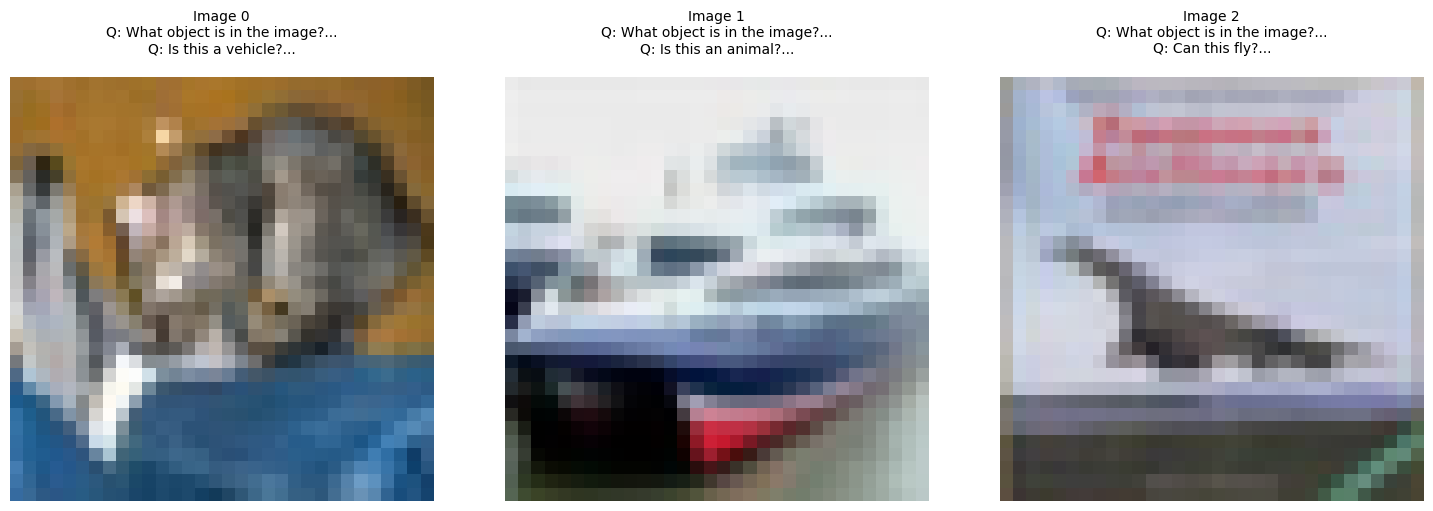

In [5]:
def visualize_samples(images, df, n_samples=3):
    fig, axes = plt.subplots(1, min(n_samples, len(images)), figsize=(15, 5))
    if n_samples == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        if idx < len(images):
            ax.imshow(images[idx])
            ax.axis('off')
            questions = df[df['image_id'] == idx]
            title = f"Image {idx}\n"
            for _, row in questions.iterrows():
                title += f"Q: {row['question'][:30]}...\n"
            ax.set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()

visualize_samples(sample_images, df, n_samples=3)

## 4. Baseline: ResNet + T5

Создадим простой бейз, который:
1. Извлекает эмбеддинги изображений через предобученный ResNet50
2. Извлекает эмбеддинги вопросов через T5-small
3. Объединяет их и предсказывает ответ через MLP

### Задание 4.1: Извлеките эмбеддинги изображений

**Что нужно сделать:**
- Загрузите предобученный ResNet50
- Удалите последний слой классификации (голову)
- Извлеките эмбеддинги для всех изображений

In [6]:
class ImageEncoder:
    def __init__(self):
        self.model = models.resnet50(pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()
        self.model.to(device)
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def encode(self, images):
        batch = torch.stack([self.transform(img) for img in images]).to(device)
        with torch.no_grad():
            embeddings = self.model(batch)
        return embeddings.squeeze()

image_encoder = ImageEncoder()
image_embeddings = image_encoder.encode(sample_images)

print(f"Размерность эмбеддингов изображений: {image_embeddings.shape if image_embeddings is not None else 'Fuck'}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 87.7MB/s]


Размерность эмбеддингов изображений: torch.Size([7, 2048])


### Задание 4.2: Извлеките эмбеддинги вопросов

**Что нужно сделать:**
- Загрузите T5-small encoder и tokenizer
- Токенизируйте все вопросы
- Получите эмбеддинги (используйте mean pooling по последней скрытой размерности)

In [7]:
class TextEncoder:
    def __init__(self, model_name='t5-small'):
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5EncoderModel.from_pretrained(model_name)
        self.model.eval()
        self.model.to(device)

    def encode(self, texts):
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

text_encoder = TextEncoder()
question_embeddings = text_encoder.encode(df['question'].tolist())
print(f'Размерность эмбеддингов вопросов: {question_embeddings.shape if question_embeddings is not None else ""}')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Размерность эмбеддингов вопросов: torch.Size([14, 512])


### Задание 4.3: Обучите MLP-классификатор

**Что нужно сделать:**
- Объедините эмбеддинги изображений и вопросов (конкатенация)
- Создайте словарь всех уникальных ответов
- Реализуйте простой MLP (2-3 слоя)
- Обучите модель на нескольких эпохах

**Примечание:** Из-за маленького датасета не ожидайте высокую точность. Цель — понять архитектуру.

In [8]:
class VQAClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, num_classes, hidden_dim=512):
        super().__init__()
        self.fc1 = nn.Linear(image_dim + text_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, image_emb, text_emb):
        x = torch.cat([image_emb, text_emb], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

answer_vocab = {ans: idx for idx, ans in enumerate(df['answer'].unique())}
idx_to_answer = {idx: ans for ans, idx in answer_vocab.items()}
print(f"\nСловарь ответов ({len(answer_vocab)} классов): {list(answer_vocab.keys())}")

model = VQAClassifier(image_embeddings.shape[1], question_embeddings.shape[1], len(answer_vocab))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Словарь ответов (9 классов): ['cat', 'no', 'ship', 'airplane', 'yes', 'frog', 'automobile', 'truck', 'dog']


In [9]:
img_emb_per_question = torch.stack([image_embeddings[img_id] for img_id in df['image_id']]).to(device)
labels = torch.tensor([answer_vocab[ans] for ans in df['answer']]).to(device)

num_epochs = 100
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(img_emb_per_question, question_embeddings)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
print('\nОбучение завершено')

Epoch [20/100], Loss: 1.0779
Epoch [40/100], Loss: 0.7687
Epoch [60/100], Loss: 0.6007
Epoch [80/100], Loss: 0.3069
Epoch [100/100], Loss: 0.0848

Обучение завершено


### Задание 4.4: Протестируйте baseline

**Что нужно сделать:**
- Выберите 2-3 примера из датасета
- Получите предсказания модели
- Выведите изображение, вопрос, истинный и предсказанный ответ

In [10]:
def predict_baseline(image_id, question):
    img_emb = image_embeddings[image_id].unsqueeze(0).to(device)
    q_emb = text_encoder.encode([question])
    with torch.no_grad():
        output = model(img_emb, q_emb)
        pred_idx = torch.argmax(output, dim=1).item()
    return idx_to_answer[pred_idx]

for i in range(min(3, len(df))):
    row = df.iloc[i]
    pred = predict_baseline(row['image_id'], row['question'])
    print(f"\nПример {i+1}:")
    print(f"Image ID: {row['image_id']}")
    print(f"Question: {row['question']}")
    print(f"True Answer: {row['answer']}")
    print(f"Predicted: {pred}")


Пример 1:
Image ID: 0
Question: What object is in the image?
True Answer: cat
Predicted: cat

Пример 2:
Image ID: 0
Question: Is this a vehicle?
True Answer: no
Predicted: no

Пример 3:
Image ID: 1
Question: What object is in the image?
True Answer: ship
Predicted: ship


## 5. CLIP Zero-Shot Baseline

CLIP — это мультимодальная модель, обученная связывать изображения и тексты. Мы используем её для zero-shot VQA:
1. Для каждой пары (изображение, вопрос) сформируем набор возможных ответов
2. Составим промпты типа "A photo of {answer}"
3. CLIP выберет наиболее вероятный ответ

### Задание 5.1: Загрузите CLIP

**Что нужно сделать:**
- Загрузите CLIP модель (используйте `openai/clip-vit-base-patch32` через transformers)
- Или используйте `open_clip` библиотеку

In [11]:
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model.to(device)
clip_model.eval()

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

### Задание 5.2: Реализуйте zero-shot VQA с CLIP

**Что нужно сделать:**
- Для каждого изображения и вопроса создайте список возможных ответов (используйте answer_vocab)
- Сформируйте промпты: \"Question: {question}. Answer: {answer}\"
- Используйте CLIP для выбора наиболее подходящего ответа

In [12]:
def predict_clip(image, question, candidate_answers):
    prompts = [f"Question: {question}. Answer: {answer}" for answer in candidate_answers]

    inputs = clip_processor(text=prompts, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    best_idx = probs.argmax().item()

    return candidate_answers[best_idx]

candidate_answers = list(answer_vocab.keys())
for i in range(min(3, len(df))):
    row = df.iloc[i]
    pred = predict_clip(sample_images[row['image_id']], row['question'], candidate_answers)
    print(f"\nПример {i+1}:")
    print(f"Question: {row['question']}")
    print(f"True Answer: {row['answer']}")
    print(f"CLIP Predicted: {pred}")


Пример 1:
Question: What object is in the image?
True Answer: cat
CLIP Predicted: yes

Пример 2:
Question: Is this a vehicle?
True Answer: no
CLIP Predicted: cat

Пример 3:
Question: What object is in the image?
True Answer: ship
CLIP Predicted: ship


## 6. LLaVA Inference

LLaVA (Large Language and Vision Assistant) — это большая мультимодальная модель, которая может генерировать текстовые ответы на вопросы об изображениях.

**Внимание:** LLaVA-1.5-7B требует ~14GB GPU памяти. Если в Colab недостаточно памяти, используйте квантизацию (8-bit) или напишите мне про датасферу.

### Задание 6.1: Загрузите LLaVA

**Что нужно сделать:**
- Загрузите модель `llava-hf/llava-1.5-7b-hf`
- При необходимости используйте квантизацию для экономии памяти

In [13]:
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16
)

llava_model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf",
    quantization_config=quantization_config,
    device_map="auto"
)
llava_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

### Задание 6.2: Генерация ответов с LLaVA

**Что нужно сделать:**
- Реализуйте функцию для генерации ответов
- Используйте формат промпта: "USER: <image>
Question: {question}
ASSISTANT:"
- Протестируйте на 2-3 примерах

In [14]:
def predict_llava(image, question):
    prompt = f"USER: <image>\nQuestion: {question}\nASSISTANT:"

    inputs = llava_processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(llava_model.device) for k, v in inputs.items()}

    with torch.no_grad():
        output = llava_model.generate(**inputs, max_new_tokens=50)

    answer = llava_processor.decode(output[0], skip_special_tokens=True)
    answer = answer.split("ASSISTANT:")[-1].strip()

    return answer

for i in range(min(3, len(df))):
    row = df.iloc[i]
    pred = predict_llava(sample_images[row['image_id']], row['question'])
    print(f"\nПример {i+1}:")
    print(f"Question: {row['question']}")
    print(f"True Answer: {row['answer']}")
    print(f"LLaVA Predicted: {pred}")


Пример 1:
Question: What object is in the image?
True Answer: cat
LLaVA Predicted: A cat is in the image.

Пример 2:
Question: Is this a vehicle?
True Answer: no
LLaVA Predicted: No

Пример 3:
Question: What object is in the image?
True Answer: ship
LLaVA Predicted: Boat


## 7. Сравнение результатов

Теперь сравним все три подхода на одних и тех же примерах.

### Задание 7.1: Соберите результаты всех моделей

Что нужно сделать:
- Для каждого примера из датасета получите предсказания от всех трёх моделей
- Создайте сравнительную таблицу
- Проанализируйте, где какая модель работает лучше

In [15]:
results = {
    'Image ID': [],
    'Question': [],
    'True Answer': [],
    'ResNet+T5': [],
    'CLIP': [],
    'LLaVA': []
}

for i, row in df.iterrows():
    image = sample_images[row['image_id']]
    question = row['question']

    results['Image ID'].append(row['image_id'])
    results['Question'].append(question)
    results['True Answer'].append(row['answer'])
    results['ResNet+T5'].append(predict_baseline(row['image_id'], question))
    results['CLIP'].append(predict_clip(image, question, candidate_answers))
    results['LLaVA'].append(predict_llava(image, question))

results_df = pd.DataFrame(results)
results_df

,Image ID,Question,True Answer,ResNet+T5,CLIP,LLaVA
0,0,What object is in the image?,cat,cat,yes,A cat is in the image.
1,0,Is this a vehicle?,no,no,cat,No
2,1,What object is in the image?,ship,ship,ship,Boat
3,1,Is this an animal?,no,no,ship,No
4,2,What object is in the image?,airplane,airplane,airplane,Airplane
5,2,Can this fly?,yes,yes,automobile,"Yes, this can fly. It is a fighter jet, design..."
6,3,What object is in the image?,frog,frog,frog,Frog
7,3,Is this a living creature?,yes,yes,frog,Yes
8,4,What object is in the image?,automobile,automobile,automobile,A car is in the image.
9,4,Is this used for transportation?,yes,yes,automobile,"Yes, this car is used for transportation. It i..."


from matplotlib import pyplot as plt
results_df['Image ID'].plot(kind='hist', bins=20, title='Image ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Question').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('CLIP').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Image ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Image ID'}, axis=1)
              .sort_values('Image ID', ascending=True))
  xs = counted['Image ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('Image ID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Question')):
  _plot_series(series, series_name, i)
  fig.legend(title='Question', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Image ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Image ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Image ID'}, axis=1)
              .sort_values('Image ID', ascending=True))
  xs = counted['Image ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('Image ID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CLIP')):
  _plot_series(series, series_name, i)
  fig.legend(title='CLIP', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Image ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['Image ID'].plot(kind='line', figsize=(8, 4), title='Image ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CLIP'].value_counts()
    for x_label, grp in results_df.groupby('Question')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Question')
_ = plt.ylabel('CLIP')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Question'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='Image ID', y='Question', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['CLIP'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='Image ID', y='CLIP', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Задание 7.2: Проанализируйте результаты

Что нужно сделать:
- Посчитайте accuracy для каждой модели
- Опишите сильные и слабые стороны каждого подхода
- Приведите примеры, где модели ошибаются или дают разные ответы

In [16]:
def calculate_accuracy(predictions, true_answers):
    correct = sum([1 for pred, true in zip(predictions, true_answers) if pred.lower() == true.lower()])
    return correct / len(true_answers)

baseline_acc = calculate_accuracy(results_df['ResNet+T5'], results_df['True Answer'])
clip_acc = calculate_accuracy(results_df['CLIP'], results_df['True Answer'])
llava_acc = calculate_accuracy(results_df['LLaVA'], results_df['True Answer'])

print("\nТочность моделей:")
print(f"ResNet+T5: {baseline_acc:.2%}")
print(f"CLIP: {clip_acc:.2%}")
print(f"LLaVA: {llava_acc:.2%}")


Точность моделей:
ResNet+T5: 100.00%
CLIP: 42.86%
LLaVA: 42.86%


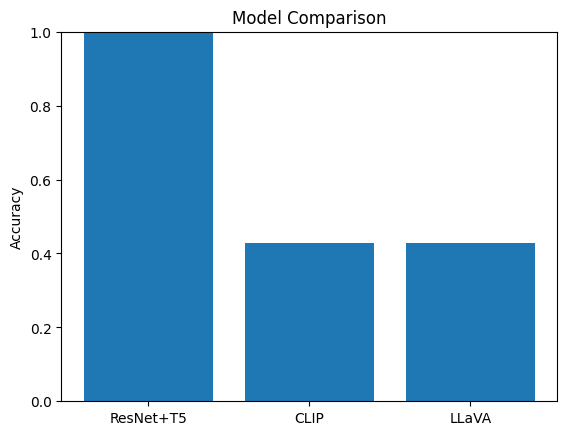

In [17]:
import matplotlib.pyplot as plt
models = ['ResNet+T5', 'CLIP', 'LLaVA']
accuracies = [baseline_acc, clip_acc, llava_acc]
plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim([0, 1])
plt.show()

### Выводы (заполните после экспериментов):

Baseline (ResNet + T5):
- Сильные стороны: очень точно отвечает на простые вопросы при фиксированном наборе ответов, стабильно распознаёт объекты и бинарные признаки, хорошо обучается на небольшом датасете
- Слабые стороны: сильно ограничен словарём и плохо переносится на новые или более сложные вопросы

CLIP:
- Сильные стороны: хорошо распознаёт объекты при прямом сопоставлении изображение–текст, не требует обучения под конкретную задачу
- Слабые стороны: не предназначен для vqa, путает типы вопросов, часто выдаёт нерелевантные ответы на yes/no-вопросы

LLaVA:
- Сильные стороны: понимает смысл вопросов, даёт осмысленные и развернутые ответы, лучше справляется с диалоговым форматом и логическими вопросами
- Слабые стороны: иногда отвечает неточно по формулировке, возможны синонимы или обобщения, из-за чего падает точность при строгой оценке

Общие наблюдения:
baseline лучше всего работает на простых закрытых вопросах, CLIP подходит скорее для классификации и matching'a, а LLaVA универсальнее для сложных и естественных вопросов

Мнения о домашке: всё круто, никакой республики бронго